# Plotting cycle to work times

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [3]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 305 entities with data


First we extract all state changes for Gaby and Charles

In [4]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)
results = db.fetch_all_data_of(people)
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

The returned Pandas dataframe has 35210 rows of data.


,domain,entity_id,state,attributes
time,,,,
2021-11-29 17:46:13.769858,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.41..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.42..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.43..."
2021-11-30 07:51:31.218973,person,person.gaby,not_home,"{""editable"":false,""id"":""gaby"",""latitude"":51.46..."
...,...,...,...,...
2022-03-10 17:38:54.519291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-03-10 21:37:55.362291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."
2022-03-10 21:37:55.362291,person,person.gaby,home,"{""editable"":false,""id"":""gaby"",""latitude"":51.40..."


In [5]:
results['time'] = results.index
results = results.drop_duplicates(subset=('domain', 'entity_id', 'state', 'time')).drop(['time', 'attributes'], axis=1)
results

,domain,entity_id,state
time,,,
2021-11-29 17:46:13.769858,person,person.gaby,home
2021-11-30 07:51:31.218973,person,person.gaby,not_home
2021-11-30 08:12:10.004068,person,person.charles,not_home
2021-11-30 08:35:23.349953,person,person.gaby,Harris Westminster
2021-11-30 09:05:18.560750,person,person.charles,Imperial
...,...,...,...
2022-03-10 17:20:04.341422,person,person.gaby,not_home
2022-03-10 17:20:04.342138,person,person.charles,home
2022-03-10 17:38:54.519291,person,person.gaby,home


Let's collect all journeys made between home and work and plot their times. 

In [6]:
journeys = {person: pd.Series() for person in people}
for person, workplace in zip(people, workplaces):
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == "home":
            try:
                for j in range(i+1, i+10):                
                    if state_changes.iloc[j] == workplace:
                        time_taken = state_changes.index[j] - state_changes.index[i+1]
                        journeys[person][state_changes.index[i+1]] = time_taken
                        break
            except IndexError:
                break
journeys

/tmp/ipykernel_567/771486441.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  journeys = {person: pd.Series() for person in people}


{'person.charles': 2021-12-01 07:57:35.007636   0 days 00:50:40.043258
 2021-12-01 08:21:09.399516   0 days 00:27:05.651378
 2021-12-04 22:05:06.231756   1 days 11:14:37.987962
 2021-12-05 10:43:00.004677   0 days 22:36:44.215041
 2021-12-05 15:56:53.686584   0 days 17:22:50.533134
                                       ...          
 2022-03-04 08:21:43.417298   0 days 00:40:22.216961
 2022-03-06 16:56:22.862370   0 days 15:48:52.186938
 2022-03-07 07:54:55.004869   0 days 00:50:20.044439
 2022-03-08 07:49:47.149174   0 days 00:33:31.188843
 2022-03-09 08:17:05.004641   0 days 00:38:48.039752
 Length: 91, dtype: timedelta64[ns],
 'person.gaby': 2021-11-30 07:51:31.218973   0 days 00:43:52.130980
 2021-12-01 07:50:55.005667   0 days 00:45:59.463352
 2021-12-01 17:52:40.006965   0 days 14:53:51.386767
 2021-12-01 19:27:00.006600   0 days 13:19:31.387132
 2021-12-02 08:01:20.007401   0 days 00:45:11.386331
                                       ...          
 2022-03-07 07:52:56.103910  

Assume that all journeys take between 20 mins and 2 hours.

In [7]:
for person, data in journeys.items():
    journeys[person] = data[(pd.Timedelta("20m") < data) & (data < pd.Timedelta("2h"))]

Store by day, as dataframe

<AxesSubplot:title={'center':'Time taken for morning commute'}, ylabel='Time / min'>

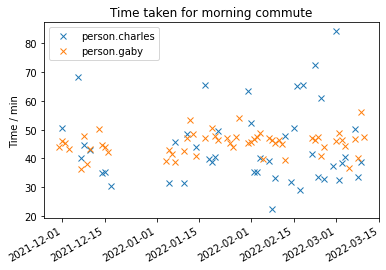

In [8]:
for person, data in journeys.items():
    data.index = data.index.round("D")
    journeys[person] = data[~data.index.duplicated()]
journeys = pd.DataFrame(journeys)
(journeys / pd.Timedelta("1m")).plot(
    ylabel="Time / min",
    title="Time taken for morning commute",
    style='x'
)

In [9]:
def extract_journey_times(results, person, from_place, to_place, plot=True):
    journeys = pd.Series(dtype='interval')
    
    state_changes = results.loc[results.entity_id == person, 'state']
    for i in range(state_changes.shape[0]):
        if state_changes.iloc[i] == from_place:
            try:
                for j in range(i+1, i+10):                
                    if state_changes.iloc[j] == to_place:
                        time_taken = state_changes.index[j] - state_changes.index[i+1]
                        journeys[state_changes.index[i+1]] = time_taken
                        break
            except IndexError:
                break
                
    journeys = journeys[(pd.Timedelta("20m") < journeys) & (journeys < pd.Timedelta("2h"))]
    

    journeys.index = journeys.index.round("D")
    journeys = journeys[~journeys.index.duplicated()]
    
    if plot:
        (journeys / pd.Timedelta("1m")).plot(
            ylabel="Time / min",
            title="Time taken for commute",
            style='x'
        )
    
    return journeys    

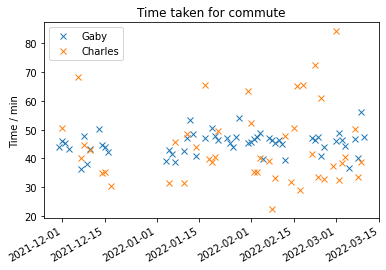

In [10]:
extract_journey_times(results, "person.gaby", "home", "Harris Westminster");
extract_journey_times(results, "person.charles", "home", "Imperial");
plt.legend(("Gaby", "Charles"));

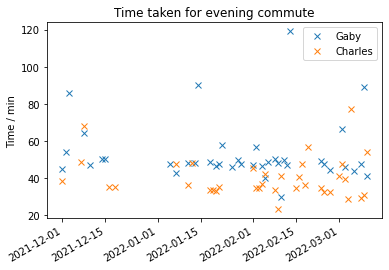

In [11]:
extract_journey_times(results, "person.gaby", "Harris Westminster", "home")
extract_journey_times(results, "person.charles", "Imperial", "home")
plt.title("Time taken for evening commute")
plt.legend(("Gaby", "Charles"));

In [12]:
journeys_evening = extract_journey_times(results, "person.charles", "Imperial", "home", plot=False)
journeys_evening['2022-02-09']

Timedelta('0 days 00:23:20.548059')

Huh?

In [13]:
results.loc[results.entity_id=='person.charles']['2022-02-08':'2022-02-10']

,domain,entity_id,state
time,,,
2022-02-08 09:02:57.208586,person,person.charles,not_home
2022-02-08 09:25:16.300267,person,person.charles,Imperial
2022-02-08 19:21:29.929851,person,person.charles,Wimbledon
2022-02-08 19:44:50.477910,person,person.charles,home
2022-02-09 09:14:32.402953,person,person.charles,not_home
2022-02-09 09:47:35.441937,person,person.charles,Imperial
2022-02-09 18:38:47.706798,person,person.charles,not_home
2022-02-09 19:19:55.906075,person,person.charles,home
2022-02-10 17:58:25.004164,person,person.charles,not_home


Something funny in the data there, but the processing is fine. Chalk that one down to GPS logging noise. 

More filtering
===============

At some point, I added Wimbledon as a location so that I could distuinguish between train and bike journeys. When was this?